# 概述

目标：本程序基于成都市地铁站点的次序数据，给出两两站点间的最短线路

两站点中的路径会有若干条，整个代码最关键的点在于确定以下哪种方式来定义**“最优”**：1. 里程或者时间最短，则为最优；2. **先考虑换乘最少，再考虑站点数量最少，则为最优(本次)**

Floyd算法或者普通递归都可以实现上述两个目标，本MD在前5部分为普通递归、Floyd算法实现参见第6部分

Floyd算法可参见：https://zhuanlan.zhihu.com/p/33162490

Dijkstra算法不适合两两计算的情况，可以参见这个视频：https://www.bilibili.com/video/BV1zz4y1m7Nq
或者这篇文章：https://zhuanlan.zhihu.com/p/129373740

# 导包导数

## 导包

In [1]:
import numpy as np
import pandas as pd
pd.set_option('max_columns', 200)
pd.set_option('max_rows', 1000)
import datetime

## 数据导入和预处理

In [2]:
station = pd.read_csv('D:/station.txt', sep='\t')
station.head()

,line,station
0,1号线,韦家碾
1,1号线,升仙湖
2,1号线,火车北站
3,1号线,人民北路
4,1号线,文殊院


原始数据包含两部分信息，一部分为各个线路对应的地铁站点（这个站点信息是事先整理好顺序的），另一部分为两两站点间的路程或者耗时

本次建模的目标为：“按照最少途径站点或者换乘+站点”作为最优评判，故**只采用了第一部分信息**。

### 数据处理

首先，一个很自然的想法是将整个城市的地铁线路进行切段。

可以整理出每个段的“站点序列”、“首尾站点”还有“归属于哪条线”（如下表），并且这个结果是唯一的。

“首尾站点”的作用用于在后续拼接线路时充当索引，“站点序列”的一个作用用于**拼接线路**，另一个作用用于**判断目标站点在不在线路内**。

|line|key_station|line_section|
|:------:|:-------:|:------:|
|1号线|韦家碾|[韦家碾, 升仙湖, 火车北站]|
|1号线|火车北站|[火车北站, 人民北路]|
|1号线|人民北路|[人民北路, 文殊院, 骡马市]|

In [3]:
s = station.groupby('station')['line'].count().reset_index()
cross_station = set(s.loc[s.line > 1].station)

e = station.groupby('line')['station'].agg(['first','last'])
end_station = set(e.values.reshape(-1))

key_station = cross_station | end_station

这里将所有换乘和终点的站点整理入一个字典，用以后续生成短路径的前后站点

#### 生成站点序列数据

In [4]:
# 正序
line_section = []
line_collect = []

i = 0
while i < len(station):
    l = station.iloc[i]['line']
    s = station.iloc[i]['station']
    
    try:
        next_l = station.iloc[i+1]['line']
    except:
        next_l = ''
    
    if s in key_station and len(line_section) == 0 and l == next_l: # start
        line_collect.append(l)
        line_collect.append(s)
        line_section.append(s)
        i += 1
    elif s in key_station and len(line_section) > 0: # end
        line_section.append(s)
        line_collect.append(line_section)
        line_section = []
        if l != next_l:
            i += 1
    elif l == next_l: # normal
        line_section.append(s)
        i += 1
        
positive_order = pd.DataFrame(np.array(line_collect).reshape(-1, 3), columns=['line', 'key_station', 'line_section'])

C:\Users\DELL\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [5]:
# 逆序
station = station.sort_index(ascending=False).reset_index(drop=True)

line_section = []
line_collect = []

i = 0
while i < len(station):
    l = station.iloc[i]['line']
    s = station.iloc[i]['station']
    
    try:
        next_l = station.iloc[i+1]['line']
    except:
        next_l = ''
    
    if s in key_station and len(line_section) == 0 and l == next_l: # start
        line_collect.append(l)
        line_collect.append(s)
        line_section.append(s)
        i += 1
    elif s in key_station and len(line_section) > 0: # end
        line_section.append(s)
        line_collect.append(line_section)
        line_section = []
        if l != next_l:
            i += 1
    elif l == next_l: # normal
        line_section.append(s)
        i += 1
        
negative_order = pd.DataFrame(np.array(line_collect).reshape(-1, 3), columns=['line', 'key_station', 'line_section'])
negative_order.head(5)

C:\Users\DELL\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


,line,key_station,line_section
0,18号线,天府机场北,"[天府机场北, 天府机场1号2号航站楼, 福田, 三岔, 天府新站, 兴隆, 西博城]"
1,18号线,西博城,"[西博城, 海昌路]"
2,18号线,海昌路,"[海昌路, 世纪城]"
3,18号线,世纪城,"[世纪城, 锦城广场东, 孵化园]"
4,18号线,孵化园,"[孵化园, 火车南站]"


In [6]:
section_df = pd.concat([positive_order, negative_order]).reset_index(drop=True)
print(section_df.shape)

(200, 3)


最终生成的数据如上表示例，正向/逆向序列合并，一共200个序列段

#### 其余参与计算的数据准备

In [7]:
# 反向生成站点、短线索引
station_line_map = section_df.explode('line_section')['line_section'].reset_index().groupby('line_section')['index'].agg(list).to_dict()
station_line_map['中医大省医院']

[13, 14, 32, 33, 41, 42, 157, 158, 166, 167, 185, 186]

这个数据用于初始启动，从任意站点映射他所关联的站点序列索引

例如从 “中医大省医院” 出发，该站点由3条线路交叉、涉及6个序列段，再加上往返两个方向，一共12个索引值

In [8]:
line_station_map = station.loc[station['station'] != '7号线'].groupby('line')['station'].agg(list).to_dict()
line_station_map['1号线'][:5]

['科学城', '兴隆湖', '广州路', '西博城', '天府公园']

这个字典储存所有的线路和站点映射，用于预判断起止站点是否在同一条线路上，如在，则不需要额外的计算

# 举例计算（原码片段）

在实现主要功能计算之前，我们补一个函数，用于对list中做“临近元素相似合并”，在计算结束收集换乘线路和拼接站点序列，都会使用

In [9]:
# 去重函数
def dup_list(l):
    return [ l[i] for i in range(len(l)) if i==0 or l[i] != l[i-1] ]
    
dup_list(['5号线', '7号线', '18号线', '18号线', '18号线', '1号线'])

['5号线', '7号线', '18号线', '1号线']

以下将基于“华府大道”到“大源”作为举例，在百度地图查询换乘方案，是一个∩型

我们采用**无放回 + 线路拼接**的方式从出发站点开始**递归拼取**站点序列段；**终止条件**为终点在将要取的序列段上；**剪枝**则由一个global变量控制，作为阈值角色他将继续下发到每个子递归中

该global变量非常重要，在获得一个完整的通路方案后，将由例如途径站点数量更新该值，则后续子递归一旦超过阈值，则可以停止后续递归

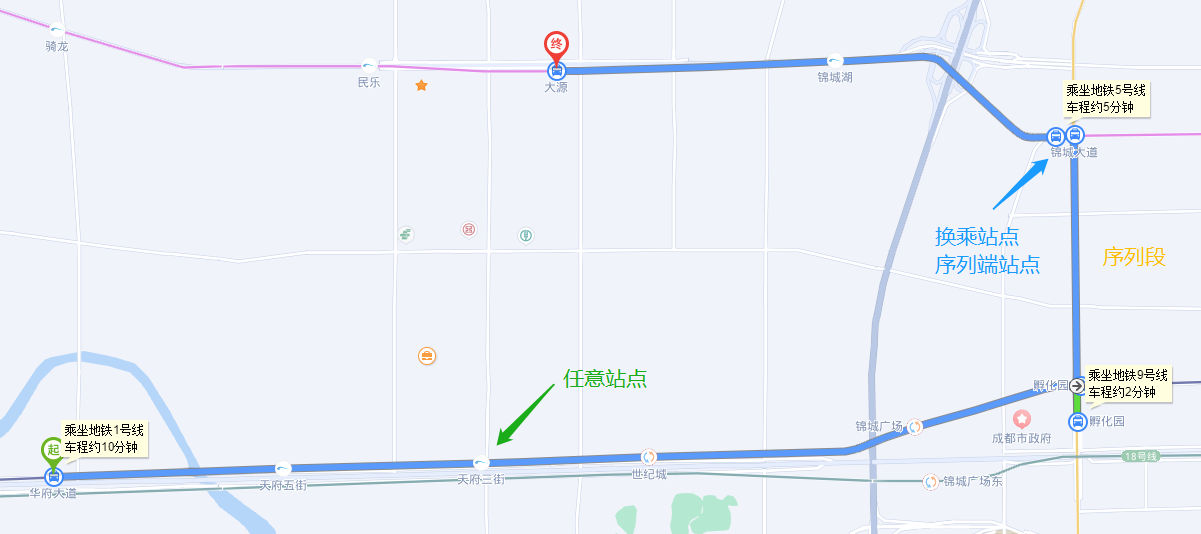

In [10]:
# 起止站点
start = '华府大道'
to = '大源'

station_collect = []  # 沿途站点序列收集
line_collect = []  # 沿途线路序列收集
station_cnt = 50  # 剪枝阈值

section_df_loop = section_df.values.copy()  # 站点序列袋

def line_join(key_station='', station_series=[], line_series=[], section_df_sub=[], start_loop=''):
    # key_station='',  站点序列的端站点
    # station_series=[], line_series=[],  之前已经收集的拼接好的站点序列和线路序列 
    # section_df_sub=[],  上次循环后传入的站点序列袋
    # start_loop=''  定义，则从任意站点开始往后迭代
    
    global station_cnt
    
    if len(start_loop) > 0:  # 从任意站点开始迭代？还是从站点序列端站点开始迭代
        section_df_loop = section_df_sub[station_line_map[start]][:,[0,2]]  # 所有由站点关联到的序列段，用于后续添加序列段或者作为分支分叉递归 
        section_df_subx = np.delete(section_df_sub, station_line_map[start], axis=0)  # 更新袋，剔除本次关联到的序列段
    else:
        section_df_loop = section_df_sub[section_df_sub[:,1] == key_station][:,[0,2]]
        section_df_subx = section_df_sub[section_df_sub[:,1] != key_station]
    
    for m in section_df_loop:      
        if to in m[1]:  # 判断终点在不在某条序列段上
            line_collect.append(dup_list(line_series + [m[0]]))  # 线路序列输出
            station_collect.append(dup_list(station_series + m[1]))  # 站点序列输出
            station_cnt = min(station_cnt, len(station_series + m[1]))  # 更新剪枝阈值
        elif len(station_series + m[1]) <= station_cnt:  # 这里，如果终点不在当前序列段，并且，当前收集的序列段已经超过阈值，则剪枝不再递归
            line_join(key_station=m[1][-1], station_series=station_series + m[1], line_series=line_series + [m[0]], 
                      section_df_sub=section_df_subx, )  # 更新状态，递归 
            
line_join(start_loop=start, station_series=[], line_series=[], section_df_sub=section_df_loop)

# 将生成的结果做起止截尾
station_collect = [x[x.index(start):x.index(to)+1] for x in station_collect if len(x[x.index(start):x.index(to)+1]) > 0]

# 找最小
ways_collect = pd.DataFrame([line_collect, station_collect]).T
ways_collect.columns = ['line_collect', 'station_collect']
ways_collect['line_collect_len'] = ways_collect['line_collect'].map(len)
ways_collect['station_collect_len'] = ways_collect['station_collect'].map(len)

ways_collect = list(ways_collect.sort_values(['line_collect_len', 'station_collect_len']).head(1).values)
print(ways_collect[0][0], ways_collect[0][1])

['1号线', '9号线', '5号线'] ['华府大道', '天府五街', '天府三街', '世纪城', '锦城广场', '孵化园', '锦城大道', '锦城湖', '大源']


# 全量循环

在完成单例开发以后，剩下就可以对全部两两站点进行遍历，只不过每一对站点我们只需要计算一次便可

In [11]:
loop_list = list(set(station.station))
loop_list = pd.Series(loop_list, name='col')
loop_list.index = [0] * len(loop_list)
loop_list = pd.merge(loop_list, loop_list, left_index=True, right_index=True)
loop_list['start'], loop_list['to'] = list(zip(*loop_list.apply(lambda x:np.sort([x['col_x'], x['col_y']]), axis=1)))

loop_order = loop_list.loc[loop_list.start != loop_list.to, ['start', 'to']].drop_duplicates().sort_values(['start', 'to'])
loop_order = loop_order.reset_index(drop=True)
loop_order.head(2)

,start,to
0,一品天下,万安
1,一品天下,万年场


和上节示例代码稍有不同的是，这次加入了起止站点是否属于单条线路预判断，做个短路优化

In [12]:
# station_cnt必须使用global，否则无法透传影响平行循环
station_cnt = 50

def search_loop(start, to): 
    x = station.loc[(station['station'].isin([start, to])) & (station['station'] != '7号线')].groupby('line').count().reset_index()
    l = list(x.loc[x['station'] == 2, 'line'])
    if len(l) > 0: # 子判断，是否属于同一条线
        x = line_station_map[l[0]]
        if len(x[x.index(start):x.index(to)+1]) > 0:
            x = x[x.index(start):x.index(to)+1]
        else:
            x = x[x.index(to):x.index(start)+1]
            x.reverse()
        
        return [l[0]], x
    else: # 不是，走最短路径计算
        section_df_loop = section_df.values.copy()
        
        station_collect = []
        line_collect = []
            
        def line_join(key_station='', start_loop='', station_series=[], line_series=[], section_df_sub=[]):
            global station_cnt
            
            if len(start_loop) > 0:
                section_df_loop = section_df_sub[station_line_map[start]][:,[0,2]] # line + station
                section_df_subx = np.delete(section_df_sub, station_line_map[start], axis=0) # 全有 
            else:
                section_df_loop = section_df_sub[section_df_sub[:,1] == key_station][:,[0,2]]
                section_df_subx = section_df_sub[section_df_sub[:,1] != key_station]
                        
            # 终点判断
            station_cntx = [len(x) for x in section_df_loop[:,1] if to in x]
            if len(station_cntx) > 0:
                station_cnt = min(min(station_cntx) + len(station_series), station_cnt) # 更新标值
                    
            for m in section_df_loop:      
                if to in m[1]: # 判断终点
                    line_collect.append(dup_list(line_series + [m[0]])) # 线路序列输出
                    station_collect.append(dup_list(station_series + m[1])) # 站点序列输出
                elif len(station_series + m[1]) <= station_cnt:
                    line_join(key_station=m[1][-1], station_series=station_series + m[1], line_series=line_series + [m[0]], 
                              section_df_sub=section_df_subx, ) # 递归  
        
        line_join(start_loop=start, station_series=[], line_series=[], section_df_sub=section_df_loop, )
        
        # 起止截尾
        station_collect = [x[x.index(start):x.index(to)+1] for x in station_collect if len(x[x.index(start):x.index(to)+1]) > 0]
        
        # 找最小
        ways_collect = pd.DataFrame([line_collect, station_collect]).T
        ways_collect.columns = ['line_collect', 'station_collect']
        ways_collect['line_collect_len'] = ways_collect['line_collect'].map(len)
        ways_collect['station_collect_len'] = ways_collect['station_collect'].map(len)
        
        ways_collect = list(ways_collect.sort_values(['line_collect_len', 'station_collect_len']).head(1).values)
        return ways_collect[0][0], ways_collect[0][1]
    
search_loop(start='天府三街', to='成都东客站')

(['1号线', '7号线'],
 ['天府三街',
  '世纪城',
  '锦城广场',
  '孵化园',
  '金融城',
  '高新',
  '火车南站',
  '三瓦窑',
  '琉璃场',
  '四川师大',
  '狮子山',
  '大观',
  '成都东客站'])

批量计算

In [13]:
N = 100
result_collect = []
for i, row in enumerate(loop_order.head(N).values):
    station_cnt = 50
    if i % 10 == 0:
#         print(i)
        pass
    try:
        result_collect.append((row[0], row[1]) + search_loop(start=row[0], to=row[1]))
    except:
        print('Error:', row[0], row[1])
        
pd.DataFrame(result_collect).head(2)

,0,1,2,3
0,一品天下,万安,"[7号线, 6号线]","[一品天下, 金沙博物馆, 文化宫, 东坡路, 龙爪堰, 武侯大道, 太平园, 高朋大道, ..."
1,一品天下,万年场,"[2号线, 4号线]","[一品天下, 蜀汉路东, 白果林, 中医大省医院, 宽窄巷子, 骡马市, 太升南路, 市二医..."


# 差缺补漏（省略）

In [ ]:
output_collect = []
file_list = !dir D:
for f in [x[x.index('sect'):] for x in file_list if 'section_calc_output_' in x]:
    output_collect.append(pd.read_csv('D:/'+f, names=['from','to','line_cnt','section_cnt','line','section']))

In [ ]:
output_collect = pd.concat(output_collect).drop_duplicates()
output_collect.head(2)

## 数据处理

In [ ]:
output_collect['line_str'] = output_collect['line'].map(lambda x:'-'.join(eval(x)))
output_collect['section_str'] = output_collect['section'].map(lambda x:'-'.join(eval(x)))
output_collect.drop(['line','section'],axis=1).to_csv('D:/section_calc_output_combin.csv', index=False, header=False, encoding='UTF-8')

In [ ]:
need_loop = pd.merge(loop_order, output_collect[['from','to','line_cnt']], left_on=['start','to'], right_on=['from','to'], how='left')
sum(need_loop.line_cnt.isnull())

In [ ]:
strat_time = datetime.datetime.now()
loop_time = datetime.datetime.now()

result_collect = []
for i, row in enumerate(need_loop[need_loop.line_cnt.isnull()][['start','to']].values):
    station_cnt = 50
    if i % 10 == 0:
        print('经过：',i,'条，耗时：',round((datetime.datetime.now()-loop_time).seconds / 60,4), '分','\n')
    try:
        result_collect.append((row[0], row[1]) + search_loop(start=row[0], to=row[1]))
    except:
        print('Error:', row[0], row[1])

output = pd.DataFrame(result_collect)
output.columns = ['from', 'to', 'line', 'section']


output['line_cnt'] = output.line.map(len)
output['section_cnt'] = output.section.map(len)
output_path = 'D:\\section_calc_output_cqbl.csv'
print('结果输出至：', output_path)
output[['from','to','line_cnt','section_cnt','line','section']].to_csv(output_path, index=False, header=False, encoding='UTF-8')

# Floyd算法

Floyd算法基于动态规划的思路，大道至简的解决两两站点间的最短路径，核心代码只有3个for循环，基于286个站点计算 ≤ 2分钟

In [14]:
def dup_list(l):
    return [ l[i] for i in range(len(l)) if i==0 or l[i] != l[i-1] ]
    
dup_list(['5号线', '7号线', '18号线', '18号线', '18号线', '1号线'])

['5号线', '7号线', '18号线', '1号线']

In [15]:
station = pd.read_csv('D:/station.txt', sep='\t')

## 数据处理

In [16]:
# 初始化
station_line_index = []
for i in range(len(station)):
    l = station.line[i]
    s = station.station[i]
    
    try:
        l_next = station.line[i+1]
        s_next = station.station[i+1]
    except:
        l_next = ''
        s_next = ''
        
    if l == l_next:
        station_line_index.append([(s, s_next), l])
        station_line_index.append([(s_next, s), l])
        
# 7号线环线   
station_line_index.append([('火车北站', '北站西二路'), '7号线'])
station_line_index.append([('北站西二路', '火车北站'), '7号线'])

print(station_line_index[:5])
station_line_index = dict(station_line_index)

[[('韦家碾', '升仙湖'), '1号线'], [('升仙湖', '韦家碾'), '1号线'], [('升仙湖', '火车北站'), '1号线'], [('火车北站', '升仙湖'), '1号线'], [('火车北站', '人民北路'), '1号线']]


station_line_index是一个字典类型，key用于储存成都市地铁两两相邻站点，value用于储存对应归属于几号线

In [17]:
# 计算去重后的站点数量
station_nodup = pd.Series(station.station.unique())
l_cnt = len(station_nodup)
l_cnt

286

对于站点来说，他在计算当中是不应该归属于某一条线路的，所以这里必须去重，否则后续计算出的路径无法跨线

## 初始化

在初始化阶段我们需要定义两个矩阵：weight_mat和track_mat

weight_mat用于记录状态，他表达了当前计算后的两两站点之间是否是通路，如果是通路，他的最小度量值是多少？

track_mat用于记录当前最小度量值对应的线路序列或者站点序列

In [19]:
weight_mat = np.ones([l_cnt, l_cnt]) * 999
track_mat = np.array([[{'line':[], 'station':[]} for x in range(l_cnt)] for y in range(l_cnt)])

# 对角线置0
for i in range(l_cnt):
    weight_mat[i, i] = 0
    
# 初始邻接站点置1
station_index_map = dict([(v,k) for k,v in station_nodup.to_dict().items()])  # 站点名称和rank索引
for f, t in station_line_index.keys():
    weight_mat[station_index_map[f], station_index_map[t]] = 1  # 权重矩阵初始化
    track_mat[station_index_map[f], station_index_map[t]]['station'] = [f, t]  # 站点序列初始化
    track_mat[station_index_map[f], station_index_map[t]]['line'] = [station_line_index[(f, t)]]  # 线路初始化

## Floyd循环算法

In [20]:
# Floyd循环
weight_mat_cl = weight_mat.copy()

for k in range(l_cnt):
    for i in range(l_cnt):
        for j in range(l_cnt):
            if i != j and j != k and k != i:
                new_weight = weight_mat_cl[i, k] + weight_mat_cl[k, j]
                new_station = dup_list(track_mat[i, k]['station'] + track_mat[k, j]['station'])
                new_line = dup_list(track_mat[i, k]['line'] + track_mat[k, j]['line'])
                
#                 if new_weight < weight_mat_cl[i, j]:  # 只看边权重
                if ((weight_mat_cl[i, j] == 999) & (new_weight < 999)) | \
                    ((len(new_line) < len(track_mat[i, j]['line'])) & (weight_mat_cl[i, j] + new_weight < 999)) | \
                    ((len(new_line) == len(track_mat[i, j]['line'])) & (new_weight < weight_mat_cl[i, j])):  # 看线路和边权重
                    weight_mat_cl[i, j] = new_weight
                    track_mat[i, j]['station'] = new_station
                    track_mat[i, j]['line'] = new_line

Floyd循环分为k,i,j三层循环，i和j对应的就是权重矩阵的坐标，k对应的是状态变化（也可以理解为在i和j构造好的坐标系之上，一个点一个点的添加桥梁点）

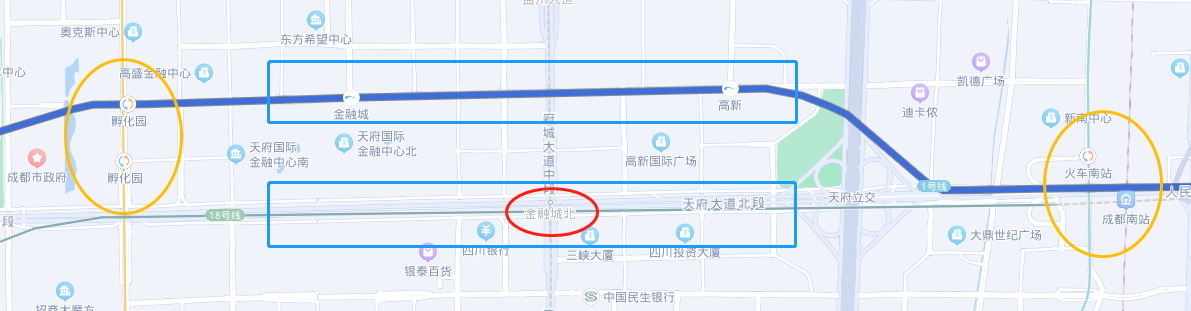

以“孵化园”至“火车南站”为例加以说明：

初始状态下，权重矩阵中的孵化园→金融城北权重为1（邻接），但是孵化园→火车南站的权重为999

在外层k循环的某次迭代中（下线），金融城北加入了决策，孵化园→金融城北（1）+ 金融城北→火车南站（1） < 孵化园→火车南站（999），状态更新

在k+1次循环中（上线），例如已经积累了孵化园→高新的权重 < 999，但是孵化园→火车南站依然不通（999），这时第k次循环中火车南站引入，状态更新

在代码中的更新条件，一种方案是只看边权重，另一种方案是综合看换乘+边权重。如果只看边权重，上图从地铁一号线经过孵化园时会换乘18号线

## 结果验证、导出

In [22]:
def tmp_calc(f, t):
    track = track_mat[station_index_map[f], station_index_map[t]]
    return f, t, len(track['line']), len(track['station']), track['line'], track['station']

tmp_calc('天府三街', '春熙路')

('天府三街',
 '春熙路',
 2,
 13,
 ['1号线', '3号线'],
 ['天府三街',
  '世纪城',
  '锦城广场',
  '孵化园',
  '金融城',
  '高新',
  '火车南站',
  '桐梓林',
  '倪家桥',
  '省体育馆',
  '磨子桥',
  '新南门',
  '春熙路'])

### 批量计算

In [ ]:
loop_list = list(set(station.station))
loop_list = pd.Series(loop_list, name='col')
loop_list.index = [0] * len(loop_list)
loop_list = pd.merge(loop_list, loop_list, left_index=True, right_index=True)

In [ ]:
calc_list = loop_list.loc[loop_list.col_x != loop_list.col_y].apply(lambda x:tmp_calc(x['col_x'], x['col_y']), axis=1)
output_path = 'D:\\section_calc_output_floyd.csv'
pd.DataFrame([i for i in calc_list], columns=['from','to','line_cnt','section_cnt','line','section']).to_csv(output_path, index=False, header=False, encoding='UTF-8')